In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
from time import time
import datetime

import numpy as np
import pandas as pd
import pandas_datareader.data as web

from scipy.stats import spearmanr

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
DATA_DIR = Path('/Volumes/My Book/Data_Analysis')

In [6]:
data = pd.read_hdf(DATA_DIR / 'Data/backtest.h5', 'data')
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 185483 entries, ('AAPL', Timestamp('2014-12-09 00:00:00')) to ('ZTS', Timestamp('2017-11-30 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   predicted  74030 non-null   float64
 1   open       185483 non-null  float64
 2   high       185483 non-null  float64
 3   low        185483 non-null  float64
 4   close      185483 non-null  float64
 5   volume     185483 non-null  float64
dtypes: float64(6)
memory usage: 10.0+ MB


In [7]:
sp500 = web.DataReader('SP500', 'fred', '2014', '2018').pct_change()

In [8]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 993 entries, 2014-03-13 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP500   992 non-null    float64
dtypes: float64(1)
memory usage: 15.5 KB


In [9]:
daily_returns = data.open.unstack('ticker').sort_index().pct_change()
daily_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 751 entries, 2014-12-09 to 2017-11-30
Columns: 251 entries, AAPL to ZTS
dtypes: float64(251)
memory usage: 1.4 MB


In [10]:
fwd_returns = daily_returns.shift(-1)

In [11]:
predictions = data.predicted.unstack('ticker')
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 751 entries, 2014-12-09 to 2017-04-14
Columns: 251 entries, AAPL to ZTS
dtypes: float64(251)
memory usage: 1.4 MB


In [12]:
N_LONG = N_SHORT = 15

In [13]:
long_signals = ((predictions
                .where(predictions > 0)
                .rank(axis=1, ascending=False) > N_LONG)
                .astype(int))
short_signals = ((predictions
                  .where(predictions < 0)
                  .rank(axis=1) > N_SHORT)
                 .astype(int))

In [14]:
# Compute portfolio returns
long_returns = long_signals.mul(fwd_returns).mean(axis=1)
short_returns = short_signals.mul(-fwd_returns).mean(axis=1)
strategy = long_returns.add(short_returns).to_frame('Strategy')

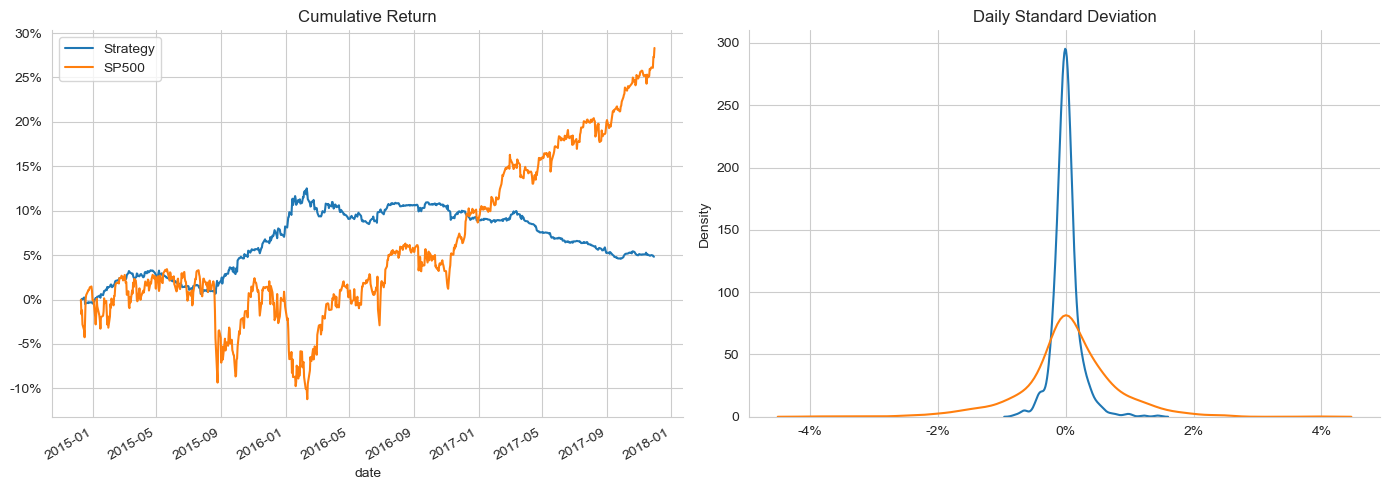

In [15]:
# Plot Results
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy.join(sp500).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(sp500, ax=axes[1], hist=False, label='SP500')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
sns.despine()
fig.tight_layout();

In [16]:
res = strategy.join(sp500).dropna()

In [17]:
res.std()

Strategy    0.002073
SP500       0.007923
dtype: float64

In [18]:
res.corr()

,Strategy,SP500
Strategy,1.00000,-0.10371
SP500,-0.10371,1.00000
